# Monkey Stocks

O objetivo deste notebook é executar um backtesting de uma estratégia de seleção aleatória de portfolio baseada em [monkey stocks](https://www.instagram.com/monkeystocks/?hl=pt-br). A estratégia consiste, basicamente, em selecionar aleatoriamente 5 ativos da bolsa brasileira semanalmente para se manter comprado ao longo do periodo em questão.

## Bibliotecas

Foram necessários os seguintes módulos de python, para executar a estratégia.

Inicialmente, é necessário obter os tickers das empresas listadas na [B3](http://www.b3.com.br/pt_br/), portanto, foi feito um crawler utilizando as bibliotecas [BeatifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) e [requests](https://requests.readthedocs.io/en/master/).

Os dados de mercado foram obtidos da biblioteca [yfinance](https://aroussi.com/post/python-yahoo-finance) que busca os dados da API do [yahoo finance](https://finance.yahoo.com).

A seleção aleatória da carteira de investimentos foi feita a partir do módulo [random](https://docs.python.org/2/library/random.html), interno de python.

E as demais bibliotecas: numpy, pandas e matplotlib, foram utilizadas para visualização e manipulação de dados.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from bs4 import BeautifulSoup
import requests

## Crawler dos Tickers da B3
A função abaixo foi desenvolvida em nosso módulo [Quant-Utils](https://github.com/GrupoTuring/Quant-Utils), ela obtém a partir do site [Fundamentus](https://fundamentus.com.br) todos os tickers das empresas listadas na [B3](http://www.b3.com.br/pt_br/). Podendo ser filtrados por setor, conforme pode-se observar abaixo.

In [2]:
def get_tickers(setor="Todos"):
    '''
    Essa função obtém os tickers listados no site fundamentus.com.br, seja um setor
    específico, uma lista de setores ou todos os tickers de todos os setores.
    '''
    
    setores = {"Agropecuária": "42", "Água e Saneamento": "33", "Alimentos": "15",
               "Bebidas": "16", "Comércio": "27", "Comércio2": "12",
               "Comércio e Distribuição": "20", "Computadores e Equipamentos": "28",
               "Construção e Engenharia": "13", "Diversos": "26",
               "Embalagens": "6", "Energia Elétrica": "32",
               "Equipamentos Elétricos": "9", "Exploração de Imóveis": "39",
               "Financeiros": "35", "Fumo": "17", "Gás": "34", 
               "Holdings Diversificadas": "40", "Hoteis e Restaurantes": "24",
               "Madeira e Papel": "5", "Máquinas e Equipamentos": "10", 
               "Materiais Diversos": "7", "Material de Transporte": "8",
               "Mídia": "23", "Mineração": "2", "Outros": "41",
               "Petróleo, Gás e Biocombustíveis": "1", "Previdência e Seguros": "38",
               "Prods. de Uso Pessoal e de Limpeza": "18", "Programas e Serviços": "29",
               "Químicos": "4", "Saúde": "19", "Securitizadoras de Recebíveis": "36",
               "Serviços": "11", "Serviços Financeiros Diversos": "37",
               "Siderurgia e Metalurgia": "3", "Tecidos, Vestuário e Calçados": "21",
               "Telefonia Fixa": "30", "Telefonia Móvel": "31", "Transporte": "14",
               "Utilidades Domésticas": "22", "Viagens e Lazer": "25"}

    lista_setores = []
    if setor == "Todos":
        lista_setores = list(setores.keys())
    elif isinstance(setor, str):
        if setores.has_key(setor):
            lista_setores.append(ticker)
        else:
            print("Esse setor não existe")
            return []
    elif isinstance(setor, list):
        lista_setores = setor
    else: 
        return []
    
    tickers = []

    for item in lista_setores:
        try:
            url = "https://www.fundamentus.com.br/resultado.php?setor=" + setores[item]
            response = requests.get(url)
        except:
            print("Não foi possível coletar informações do setor: " + item)
            continue

        soup = BeautifulSoup(response.text, "html.parser")
        tickers_bruto = soup.find('tbody').find_all("a")
        for ticker in tickers_bruto:
            tickers.append(ticker.string + '.SA')
        
    tickers.sort()
    return tickers

Em seguida executamos a função ```get_tickers()``` que retorna uma lista de python com os tickers das empresas listadas.

Exemplo:
    - ITSA4.SA
    - BIDI11.SA

In [3]:
# tickers e random tickers
tickers = get_tickers()

## Dados históricos de Mercado

A função ```yf.download()``` retorna um pandas.DataFrame com os dados relacionados ao preço dos ativos para todos os ativos passados no parâmetro. Além disso, é necessário passar os parâmetros start e end, para dizer qual o periodo que se deseja obter os dados. Em caso de dúvidas vejam a [documentação](https://github.com/ranaroussi/yfinance).

Note que nem todos os tickers estão disponíveis no periodo solicitado (talvez o ativo tenha sido retirado da bolsa ou ainda não esteja presente), nesses casos o pandas.DataFrame contém todos os valores NAN.

In [4]:
start="2019-01-01" # inicio do periodo a ser analisado
end="2019-12-31" # fim do periodo

# dados historicos de mercado dos ativos (tickers)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  402 of 402 completed

4 Failed downloads:
- LWSA3.SA: Data doesn't exist for startDate = 1546308000, endDate = 1577761200
- MTRE3.SA: Data doesn't exist for startDate = 1546308000, endDate = 1577761200
- PRNR3.SA: Data doesn't exist for startDate = 1546308000, endDate = 1577761200
- MDNE3.SA: Data doesn't exist for startDate = 1546308000, endDate = 1577761200


A função abaixo ```assets_return()``` calcula o retorno semanal dos tickers passados como parâmetro utilizando os preços de fechamento. E retorna um pandas.DataFrame contendo a soma dos retornos de cada ativo (sum) e média dos retornos (mean). 

In [5]:
def assets_return(data, start, end, tickers):
    
    df = data.Close[tickers].loc[start:end].pct_change().dropna()

    df['sum'] = df.sum(axis=1)
    df['mean'] = df.mean(axis=1)
    return df[['sum', 'mean']]

A função principal desse notebook é a que segue ```monkey_stocks()``` que recebe os dados de preço de todos os ativos listados para o periodo analisado. E retorna um dataframe contendo os retornos semanais obtidos pela carteira.

Para cada semana no periodo analisado, escolhemos aleatoriamente 5 ativos das empresas listadas na B3 e calculamos o seu retorno com base nos preços de fechamento. Em que o retorno ($r_t$) é performado pelo método ```pct_change()``` do pandas.DataFrame

$$r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$



In [6]:
def monkey_stocks(data):

    df = pd.DataFrame()
    
    # a cada semana
    start2 = data.index[0]
    for i in range(4, len(data.index), 4):
        end2 = data.index[i]
        
        random_tickers = random.sample(tickers, 5)
        
        print(f"Calculando semana {start} - {end}")
        print(f"Tickers = {random_tickers}")
        
        r = assets_return(data, start2, end2, random_tickers)
        
        df = pd.concat([df, r])
        
        start2 = end2
        
    return df

Abaixo temos a chamada da função que executa a estratégia. Performe mais de uma execução e visualize o resultado na seção de visualização.

In [7]:
# chamada da função monkey_stocks()
ms = monkey_stocks(data)

Calculando semana 2019-01-01 - 2019-12-31
Tickers = ['LAME4.SA', 'GEPA3.SA', 'GFSA3.SA', 'PNVL4.SA', 'AHEB3.SA']
Calculando semana 2019-01-01 - 2019-12-31
Tickers = ['CPRE3.SA', 'AFLT3.SA', 'AHEB3.SA', 'BRAP4.SA', 'TRPL4.SA']
Calculando semana 2019-01-01 - 2019-12-31
Tickers = ['STBP3.SA', 'BBSE3.SA', 'DMMO3.SA', 'CVCB3.SA', 'GGBR3.SA']
Calculando semana 2019-01-01 - 2019-12-31
Tickers = ['KLBN3.SA', 'CLSC4.SA', 'SULA11.SA', 'JFEN3.SA', 'BMGB4.SA']
Calculando semana 2019-01-01 - 2019-12-31
Tickers = ['MSPA3.SA', 'MYPK3.SA', 'MMXM3.SA', 'SPRI3.SA', 'MDIA3.SA']
Calculando semana 2019-01-01 - 2019-12-31
Tickers = ['SAPR4.SA', 'CPLE3.SA', 'CEDO4.SA', 'PRNR3.SA', 'EKTR3.SA']
Calculando semana 2019-01-01 - 2019-12-31
Tickers = ['BMEB4.SA', 'WLMM3.SA', 'BIDI4.SA', 'BRKM5.SA', 'BRKM3.SA']
Calculando semana 2019-01-01 - 2019-12-31
Tickers = ['EALT4.SA', 'PATI4.SA', 'TUPY3.SA', 'PTNT4.SA', 'SHUL4.SA']
Calculando semana 2019-01-01 - 2019-12-31
Tickers = ['LPSB3.SA', 'KLBN11.SA', 'UNIP6.SA', 'VIVA

## Visualização

A seguir um gráfico do retorno acumulado da estratégia no tempo.

Text(0, 0.5, 'Retorno Acumulado')

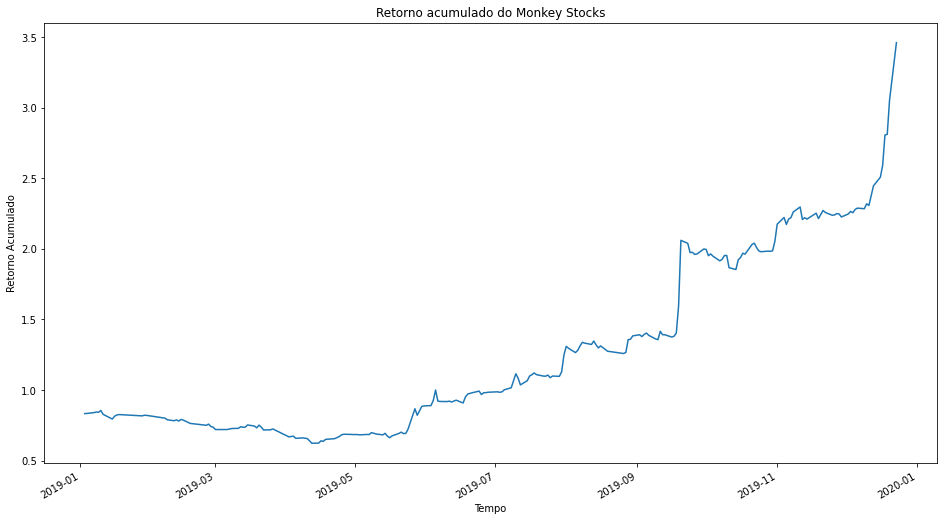

In [8]:
plt.figure(figsize=(16,9))
ax = (1 + ms['mean']).cumprod().plot(title='Retorno acumulado do Monkey Stocks')
ax.set_xlabel("Tempo")
ax.set_ylabel("Retorno Acumulado")